## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp019a'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 8 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-5 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([8, 224, 224])

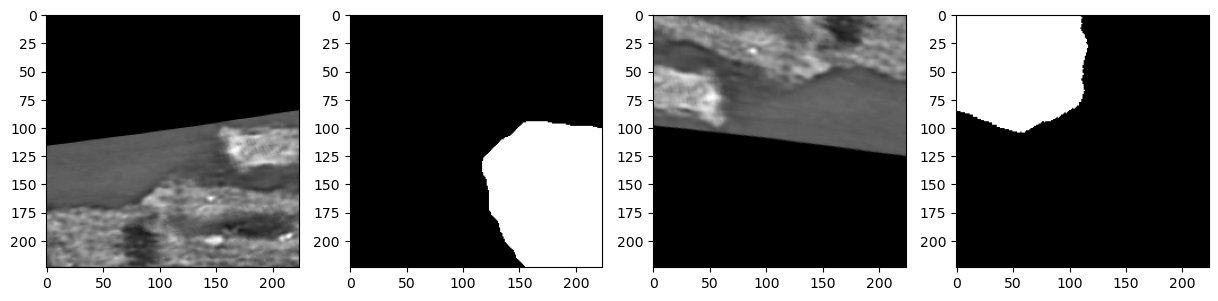

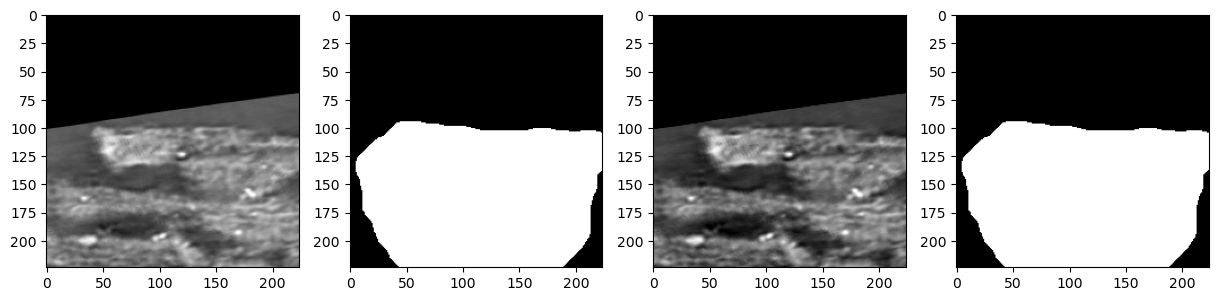

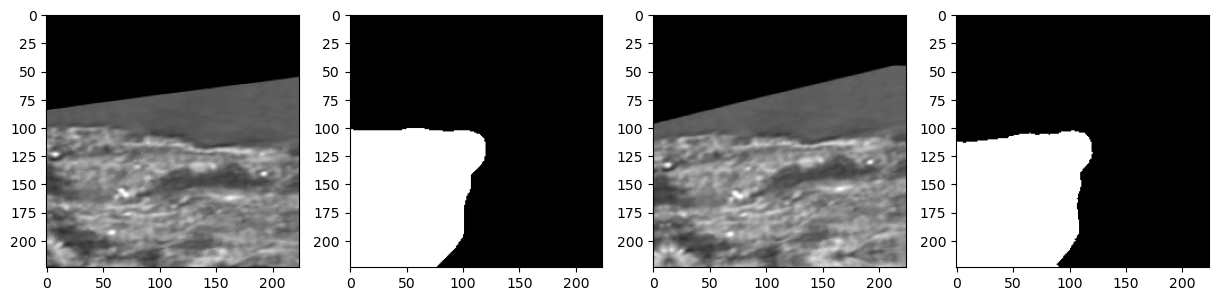

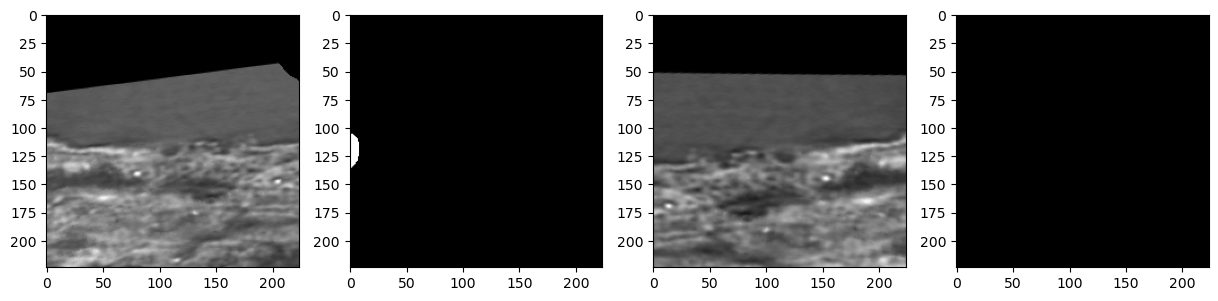

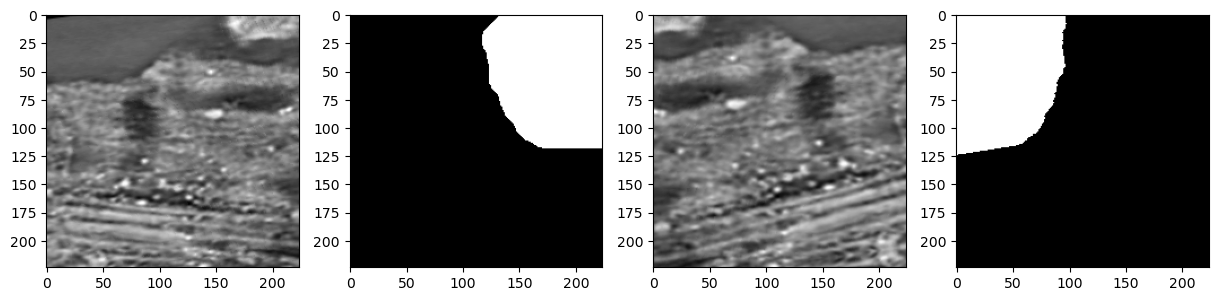

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14204711479215726
th: 0.15, fbeta: 0.14191914107435405
th: 0.2, fbeta: 0.14159013815805524
th: 0.25, fbeta: 0.14090664320535706
th: 0.3, fbeta: 0.1397058407051346
th: 0.35, fbeta: 0.1378695322686671
th: 0.4, fbeta: 0.13745408418874047
th: 0.45, fbeta: 0.1791382720200853


best_th: 0.5, fbeta: 0.1989266263821067
Epoch 1 - avg_train_loss: 0.8313  avg_val_loss: 0.7964  time: 118s
Epoch 1 - avgScore: 0.1989
Epoch 1 - Save Best Score: 0.1989 Model
Epoch 1 - Save Best Loss: 0.7964 Model


th: 0.5, fbeta: 0.1989266263821067


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14207552924102945
th: 0.15, fbeta: 0.14201869224746216
th: 0.2, fbeta: 0.14185555226860327
th: 0.25, fbeta: 0.1414668833679476
th: 0.3, fbeta: 0.14074050008792244
th: 0.35, fbeta: 0.1406575332210098
th: 0.4, fbeta: 0.18232426043041475
th: 0.45, fbeta: 0.20039537891339693


best_th: 0.5, fbeta: 0.20866207553327212
Epoch 2 - avg_train_loss: 0.7830  avg_val_loss: 0.7596  time: 120s
Epoch 2 - avgScore: 0.2087
Epoch 2 - Save Best Score: 0.2087 Model
Epoch 2 - Save Best Loss: 0.7596 Model


th: 0.5, fbeta: 0.20866207553327212


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.14208371731848443
th: 0.15, fbeta: 0.14203530258162542
th: 0.2, fbeta: 0.1418117964838235
th: 0.25, fbeta: 0.18326615976483626
th: 0.3, fbeta: 0.20236349001718035
th: 0.35, fbeta: 0.22097523233212668
th: 0.4, fbeta: 0.2389723464421387
th: 0.45, fbeta: 0.24983912662000435


best_th: 0.45, fbeta: 0.24983912662000435
Epoch 3 - avg_train_loss: 0.6052  avg_val_loss: 0.4744  time: 120s
Epoch 3 - avgScore: 0.2498
Epoch 3 - Save Best Score: 0.2498 Model
Epoch 3 - Save Best Loss: 0.4744 Model


th: 0.5, fbeta: 0.23862850283824283


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209189040641712
th: 0.15, fbeta: 0.14209950240570676
th: 0.2, fbeta: 0.18797571641050684
th: 0.25, fbeta: 0.21480255742349966
th: 0.3, fbeta: 0.24640105447773672
th: 0.35, fbeta: 0.26455549166695524
th: 0.4, fbeta: 0.23394954019784167
th: 0.45, fbeta: 0.18331855378490614


best_th: 0.35, fbeta: 0.26455549166695524
Epoch 4 - avg_train_loss: 0.4302  avg_val_loss: 0.4056  time: 119s
Epoch 4 - avgScore: 0.2646
Epoch 4 - Save Best Score: 0.2646 Model
Epoch 4 - Save Best Loss: 0.4056 Model


th: 0.5, fbeta: 0.1370201155250111


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209748875027253
th: 0.15, fbeta: 0.1433564362494486
th: 0.2, fbeta: 0.22043416925336326
th: 0.25, fbeta: 0.2954435127857923
th: 0.3, fbeta: 0.3236340742831484
th: 0.35, fbeta: 0.31240967728351937
th: 0.4, fbeta: 0.26456487884925123
th: 0.45, fbeta: 0.21469950729462686


best_th: 0.3, fbeta: 0.3236340742831484
Epoch 5 - avg_train_loss: 0.3585  avg_val_loss: 0.3690  time: 120s
Epoch 5 - avgScore: 0.3236
Epoch 5 - Save Best Score: 0.3236 Model
Epoch 5 - Save Best Loss: 0.3690 Model


th: 0.5, fbeta: 0.16763937121103398


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14212765033913585
th: 0.15, fbeta: 0.18967572110188252
th: 0.2, fbeta: 0.26807822687011346
th: 0.25, fbeta: 0.32159308510300744
th: 0.3, fbeta: 0.29628119758792604
th: 0.35, fbeta: 0.24668490071362
th: 0.4, fbeta: 0.19583235830577955
th: 0.45, fbeta: 0.15258808713907265


best_th: 0.25, fbeta: 0.32159308510300744
Epoch 6 - avg_train_loss: 0.3187  avg_val_loss: 0.3594  time: 123s
Epoch 6 - avgScore: 0.3216


th: 0.5, fbeta: 0.11542070936426489


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14221272965317816
th: 0.15, fbeta: 0.23399152275390225
th: 0.2, fbeta: 0.3518943614089997
th: 0.25, fbeta: 0.36570372338428814
th: 0.3, fbeta: 0.34756209722060266
th: 0.35, fbeta: 0.3050308412572721
th: 0.4, fbeta: 0.2549516191919103
th: 0.45, fbeta: 0.20530968477678863


best_th: 0.25, fbeta: 0.36570372338428814
Epoch 7 - avg_train_loss: 0.2936  avg_val_loss: 0.3423  time: 119s
Epoch 7 - avgScore: 0.3657
Epoch 7 - Save Best Score: 0.3657 Model
Epoch 7 - Save Best Loss: 0.3423 Model


th: 0.5, fbeta: 0.15794699169829773


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.142890977378386
th: 0.15, fbeta: 0.26435769878737786
th: 0.2, fbeta: 0.3690853445032291
th: 0.25, fbeta: 0.37714033259647145
th: 0.3, fbeta: 0.35190439426480213
th: 0.35, fbeta: 0.3043018069080628
th: 0.4, fbeta: 0.25439863015539393
th: 0.45, fbeta: 0.2060243098777518


best_th: 0.25, fbeta: 0.37714033259647145
Epoch 8 - avg_train_loss: 0.2777  avg_val_loss: 0.3375  time: 119s
Epoch 8 - avgScore: 0.3771
Epoch 8 - Save Best Score: 0.3771 Model
Epoch 8 - Save Best Loss: 0.3375 Model


th: 0.5, fbeta: 0.1628512199928832


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.20184509214858706
th: 0.15, fbeta: 0.33821942297373314
th: 0.2, fbeta: 0.3431589250884
th: 0.25, fbeta: 0.3060965521942492
th: 0.3, fbeta: 0.24992663840681587
th: 0.35, fbeta: 0.196419740050063
th: 0.4, fbeta: 0.15300558044198653
th: 0.45, fbeta: 0.1172853573235885


best_th: 0.2, fbeta: 0.3431589250884
Epoch 9 - avg_train_loss: 0.2668  avg_val_loss: 0.3396  time: 121s
Epoch 9 - avgScore: 0.3432


th: 0.5, fbeta: 0.08587931428328804


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2198644920404725
th: 0.15, fbeta: 0.34096450929203076
th: 0.2, fbeta: 0.3549585127291989
th: 0.25, fbeta: 0.33237856338309774
th: 0.3, fbeta: 0.2906181698531862
th: 0.35, fbeta: 0.2450161303001586
th: 0.4, fbeta: 0.20043352047773072
th: 0.45, fbeta: 0.15796147025659263


best_th: 0.2, fbeta: 0.3549585127291989
Epoch 10 - avg_train_loss: 0.2530  avg_val_loss: 0.3344  time: 121s
Epoch 10 - avgScore: 0.3550


th: 0.5, fbeta: 0.12027883241994036


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2344713307230313
th: 0.15, fbeta: 0.3647807509509967
th: 0.2, fbeta: 0.39227636055193393
th: 0.25, fbeta: 0.3850374901988656
th: 0.3, fbeta: 0.35260496588369517
th: 0.35, fbeta: 0.31004339669838854
th: 0.4, fbeta: 0.26414945703579135
th: 0.45, fbeta: 0.2173333418297992


best_th: 0.2, fbeta: 0.39227636055193393
Epoch 11 - avg_train_loss: 0.2436  avg_val_loss: 0.3265  time: 120s
Epoch 11 - avgScore: 0.3923
Epoch 11 - Save Best Score: 0.3923 Model
Epoch 11 - Save Best Loss: 0.3265 Model


th: 0.5, fbeta: 0.17091704434875912


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2889759281041406
th: 0.15, fbeta: 0.3847530863707525
th: 0.2, fbeta: 0.394384393524951
th: 0.25, fbeta: 0.37007524397276953
th: 0.3, fbeta: 0.3296909263975547
th: 0.35, fbeta: 0.28019637214939563
th: 0.4, fbeta: 0.23202979029259227
th: 0.45, fbeta: 0.18461358814427203


best_th: 0.2, fbeta: 0.394384393524951
Epoch 12 - avg_train_loss: 0.2317  avg_val_loss: 0.3312  time: 121s
Epoch 12 - avgScore: 0.3944
Epoch 12 - Save Best Score: 0.3944 Model
Epoch 12 - Save Best Loss: 0.3312 Model


th: 0.5, fbeta: 0.14047458713300168


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2833515072852398
th: 0.15, fbeta: 0.36811200474297684
th: 0.2, fbeta: 0.3838626339977254
th: 0.25, fbeta: 0.36459505561640737
th: 0.3, fbeta: 0.33410516951499025
th: 0.35, fbeta: 0.29280370455605453
th: 0.4, fbeta: 0.24877535942214368
th: 0.45, fbeta: 0.2034001865463005


best_th: 0.2, fbeta: 0.3838626339977254
Epoch 13 - avg_train_loss: 0.2238  avg_val_loss: 0.3294  time: 121s
Epoch 13 - avgScore: 0.3839


th: 0.5, fbeta: 0.16043451276191686


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.320640267473591
th: 0.15, fbeta: 0.3478781332056212
th: 0.2, fbeta: 0.3225231157565296
th: 0.25, fbeta: 0.2675204953727056
th: 0.3, fbeta: 0.21179532636962364
th: 0.35, fbeta: 0.1630251209557956
th: 0.4, fbeta: 0.12422075514762006
th: 0.45, fbeta: 0.09350085060274385


best_th: 0.15, fbeta: 0.3478781332056212
Epoch 14 - avg_train_loss: 0.2172  avg_val_loss: 0.3463  time: 119s
Epoch 14 - avgScore: 0.3479


th: 0.5, fbeta: 0.06768414055556894


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.335039558489566
th: 0.15, fbeta: 0.378082460827464
th: 0.2, fbeta: 0.3831817901089139
th: 0.25, fbeta: 0.363017217625994
th: 0.3, fbeta: 0.3306781867008735
th: 0.35, fbeta: 0.2912026905724609
th: 0.4, fbeta: 0.24672196957088527
th: 0.45, fbeta: 0.20086867913659365


best_th: 0.2, fbeta: 0.3831817901089139
Epoch 15 - avg_train_loss: 0.2121  avg_val_loss: 0.3361  time: 119s
Epoch 15 - avgScore: 0.3832


th: 0.5, fbeta: 0.15861692398123212


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3549903376190252
th: 0.15, fbeta: 0.3921574837024256
th: 0.2, fbeta: 0.38898371961677913
th: 0.25, fbeta: 0.3596646189493882
th: 0.3, fbeta: 0.3218177928089936
th: 0.35, fbeta: 0.2837572426698599
th: 0.4, fbeta: 0.2415840310086829
th: 0.45, fbeta: 0.19865209416232965


best_th: 0.15, fbeta: 0.3921574837024256
Epoch 16 - avg_train_loss: 0.2031  avg_val_loss: 0.3386  time: 119s
Epoch 16 - avgScore: 0.3922


th: 0.5, fbeta: 0.15859857710401018


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3490194687642057
th: 0.15, fbeta: 0.3688529913309617
th: 0.2, fbeta: 0.3478252880266434
th: 0.25, fbeta: 0.3055417864354374
th: 0.3, fbeta: 0.25890739533156704
th: 0.35, fbeta: 0.21318625065232832
th: 0.4, fbeta: 0.17023853816361623
th: 0.45, fbeta: 0.13283139787891424


best_th: 0.15, fbeta: 0.3688529913309617
Epoch 17 - avg_train_loss: 0.1989  avg_val_loss: 0.3449  time: 119s
Epoch 17 - avgScore: 0.3689


th: 0.5, fbeta: 0.10271564675509227


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3618150742248703
th: 0.15, fbeta: 0.37833270403397506
th: 0.2, fbeta: 0.34714875950730045
th: 0.25, fbeta: 0.30184687727385395
th: 0.3, fbeta: 0.2556190688115512
th: 0.35, fbeta: 0.21090544278879694
th: 0.4, fbeta: 0.1686032225362946
th: 0.45, fbeta: 0.12988774668170663


best_th: 0.15, fbeta: 0.37833270403397506
Epoch 18 - avg_train_loss: 0.1940  avg_val_loss: 0.3478  time: 119s
Epoch 18 - avgScore: 0.3783


th: 0.5, fbeta: 0.09768590945104055


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36457671379021883
th: 0.15, fbeta: 0.3809531534306169
th: 0.2, fbeta: 0.36104564491990493
th: 0.25, fbeta: 0.3249178245036305
th: 0.3, fbeta: 0.2869377229318353
th: 0.35, fbeta: 0.2453113792729937
th: 0.4, fbeta: 0.20474782641527242
th: 0.45, fbeta: 0.16767001340161122


best_th: 0.15, fbeta: 0.3809531534306169
Epoch 19 - avg_train_loss: 0.1899  avg_val_loss: 0.3493  time: 118s
Epoch 19 - avgScore: 0.3810


th: 0.5, fbeta: 0.13237959408575062


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36645770547892004
th: 0.15, fbeta: 0.3690342094022947
th: 0.2, fbeta: 0.3383410861503695
th: 0.25, fbeta: 0.2975041614168129
th: 0.3, fbeta: 0.25495140484702034
th: 0.35, fbeta: 0.20961809055524008
th: 0.4, fbeta: 0.17031104927297278
th: 0.45, fbeta: 0.13695052555361048


best_th: 0.15, fbeta: 0.3690342094022947
Epoch 20 - avg_train_loss: 0.1864  avg_val_loss: 0.3567  time: 120s
Epoch 20 - avgScore: 0.3690


th: 0.5, fbeta: 0.10759600856684605


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37254661320897525
th: 0.15, fbeta: 0.38440911040868975
th: 0.2, fbeta: 0.35922631297107493
th: 0.25, fbeta: 0.32048967418414104
th: 0.3, fbeta: 0.2781054768590872
th: 0.35, fbeta: 0.23660625836628285
th: 0.4, fbeta: 0.19481411103479365
th: 0.45, fbeta: 0.1587811413293217


best_th: 0.15, fbeta: 0.38440911040868975
Epoch 21 - avg_train_loss: 0.1840  avg_val_loss: 0.3556  time: 120s
Epoch 21 - avgScore: 0.3844


th: 0.5, fbeta: 0.12777377515551908


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36832702066179085
th: 0.15, fbeta: 0.346663204187953
th: 0.2, fbeta: 0.2944534182259841
th: 0.25, fbeta: 0.2417038976599573
th: 0.3, fbeta: 0.19266031134186634
th: 0.35, fbeta: 0.15008691834819676
th: 0.4, fbeta: 0.11628076697507109
th: 0.45, fbeta: 0.09141821213419954


best_th: 0.1, fbeta: 0.36832702066179085
Epoch 22 - avg_train_loss: 0.1819  avg_val_loss: 0.3639  time: 121s
Epoch 22 - avgScore: 0.3683


th: 0.5, fbeta: 0.07124319419932149


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36084255466198645
th: 0.15, fbeta: 0.3215243987636399
th: 0.2, fbeta: 0.2624317837590646
th: 0.25, fbeta: 0.20978372687922497
th: 0.3, fbeta: 0.1652814417299303
th: 0.35, fbeta: 0.13174637541868447
th: 0.4, fbeta: 0.10259032251513862
th: 0.45, fbeta: 0.08026276000680779


best_th: 0.1, fbeta: 0.36084255466198645
Epoch 23 - avg_train_loss: 0.1797  avg_val_loss: 0.3722  time: 120s
Epoch 23 - avgScore: 0.3608


th: 0.5, fbeta: 0.06216208276155649


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37612706262049567
th: 0.15, fbeta: 0.3711170455779818
th: 0.2, fbeta: 0.3351175905878611
th: 0.25, fbeta: 0.2925014149384109
th: 0.3, fbeta: 0.24972560046863515
th: 0.35, fbeta: 0.20748209690150998
th: 0.4, fbeta: 0.17125570909154536
th: 0.45, fbeta: 0.13846701631114666


best_th: 0.1, fbeta: 0.37612706262049567
Epoch 24 - avg_train_loss: 0.1747  avg_val_loss: 0.3655  time: 120s
Epoch 24 - avgScore: 0.3761


th: 0.5, fbeta: 0.1122673432507323


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37426635591788715
th: 0.15, fbeta: 0.3724736448325817
th: 0.2, fbeta: 0.3449359967182933
th: 0.25, fbeta: 0.30452894861517665
th: 0.3, fbeta: 0.2628317471402344
th: 0.35, fbeta: 0.2211442124025794
th: 0.4, fbeta: 0.1854313128701841
th: 0.45, fbeta: 0.1544677952572135


best_th: 0.1, fbeta: 0.37426635591788715
Epoch 25 - avg_train_loss: 0.1744  avg_val_loss: 0.3637  time: 120s
Epoch 25 - avgScore: 0.3743


th: 0.5, fbeta: 0.1261554035433119


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37050360063190063
th: 0.15, fbeta: 0.36933189381042403
th: 0.2, fbeta: 0.341482782098632
th: 0.25, fbeta: 0.3003654576457367
th: 0.3, fbeta: 0.25568466635556214
th: 0.35, fbeta: 0.21408028099933893
th: 0.4, fbeta: 0.1764524454746658
th: 0.45, fbeta: 0.1451867986688658


best_th: 0.1, fbeta: 0.37050360063190063
Epoch 26 - avg_train_loss: 0.1730  avg_val_loss: 0.3628  time: 121s
Epoch 26 - avgScore: 0.3705


th: 0.5, fbeta: 0.1163791409943398


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38204313466356477
th: 0.15, fbeta: 0.37513055411766516
th: 0.2, fbeta: 0.33933686023011156
th: 0.25, fbeta: 0.2947355163630389
th: 0.3, fbeta: 0.24792778485045058
th: 0.35, fbeta: 0.20518870456508784
th: 0.4, fbeta: 0.16759814906916298
th: 0.45, fbeta: 0.1364602627010671


best_th: 0.1, fbeta: 0.38204313466356477
Epoch 27 - avg_train_loss: 0.1724  avg_val_loss: 0.3666  time: 124s
Epoch 27 - avgScore: 0.3820


th: 0.5, fbeta: 0.1090993498764713


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3764261758820035
th: 0.15, fbeta: 0.3807068535231295
th: 0.2, fbeta: 0.3574722854546181
th: 0.25, fbeta: 0.32277167137764795
th: 0.3, fbeta: 0.28052924042604144
th: 0.35, fbeta: 0.23865165378916198
th: 0.4, fbeta: 0.20030678193749635
th: 0.45, fbeta: 0.16422784270509255


best_th: 0.15, fbeta: 0.3807068535231295
Epoch 28 - avg_train_loss: 0.1699  avg_val_loss: 0.3660  time: 128s
Epoch 28 - avgScore: 0.3807


th: 0.5, fbeta: 0.13104404951841414


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37055071805042666
th: 0.15, fbeta: 0.3724092001992841
th: 0.2, fbeta: 0.34307921034333017
th: 0.25, fbeta: 0.30193220059112635
th: 0.3, fbeta: 0.25776509690892996
th: 0.35, fbeta: 0.21693322738015922
th: 0.4, fbeta: 0.18103934317743395
th: 0.45, fbeta: 0.14746830619696072


best_th: 0.15, fbeta: 0.3724092001992841
Epoch 29 - avg_train_loss: 0.1697  avg_val_loss: 0.3626  time: 127s
Epoch 29 - avgScore: 0.3724


th: 0.5, fbeta: 0.11816613866117935


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37447889059001377
th: 0.15, fbeta: 0.36047630242917866
th: 0.2, fbeta: 0.3162590541133165
th: 0.25, fbeta: 0.2649538175430431
th: 0.3, fbeta: 0.2179481174985829
th: 0.35, fbeta: 0.17652177501738772
th: 0.4, fbeta: 0.1421455628188462
th: 0.45, fbeta: 0.11371217822757644


best_th: 0.1, fbeta: 0.37447889059001377
Epoch 30 - avg_train_loss: 0.1701  avg_val_loss: 0.3684  time: 127s
Epoch 30 - avgScore: 0.3745


th: 0.5, fbeta: 0.08792512870128896


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.2889759281041406
th: 0.15, fbeta: 0.3847530863707525
th: 0.2, fbeta: 0.394384393524951
th: 0.25, fbeta: 0.37007524397276953
th: 0.3, fbeta: 0.3296909263975547
th: 0.35, fbeta: 0.28019637214939563
th: 0.4, fbeta: 0.23202979029259227
th: 0.45, fbeta: 0.18461358814427203


best_th: 0.2, fbeta: 0.394384393524951


th: 0.5, fbeta: 0.14047458713300168


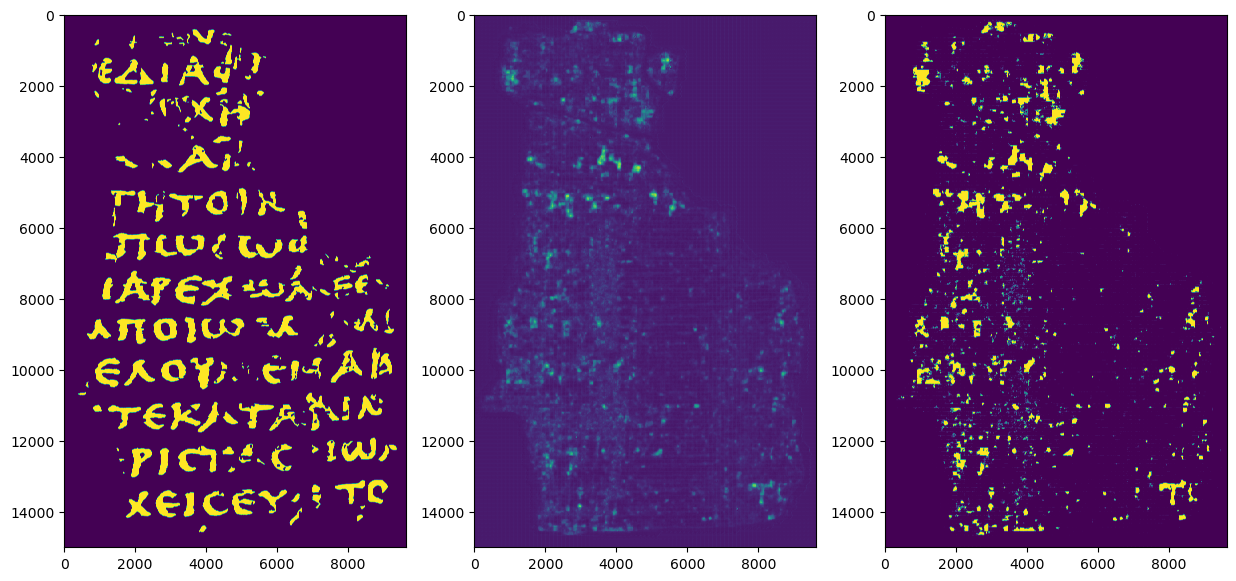

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.3588400e+05, 9.9981963e+07, 3.0925258e+07, 6.5984990e+06,
        2.7297100e+06, 1.3743980e+06, 8.8102700e+05, 5.6033200e+05,
        3.9950900e+05, 3.0082800e+05, 2.0810900e+05, 1.4233700e+05,
        1.1145100e+05, 8.8521000e+04, 5.5888000e+04, 3.6108000e+04,
        1.9076000e+04, 7.3380000e+03, 5.8700000e+02, 2.3300000e+02]),
 array([5.16036980e-05, 5.00241803e-02, 9.99967569e-02, 1.49969333e-01,
        1.99941910e-01, 2.49914487e-01, 2.99887063e-01, 3.49859640e-01,
        3.99832216e-01, 4.49804793e-01, 4.99777370e-01, 5.49749946e-01,
        5.99722523e-01, 6.49695099e-01, 6.99667676e-01, 7.49640253e-01,
        7.99612829e-01, 8.49585406e-01, 8.99557982e-01, 9.49530559e-01,
        9.99503136e-01]),
 <BarContainer object of 20 artists>)

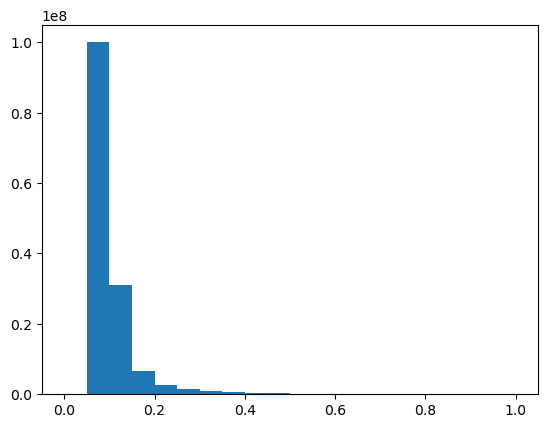

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000